In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output, display

from utils.functions import clean_uber_data



In [27]:
csv_path = "../data/uber.csv"
df = pd.read_csv(csv_path)

In [28]:
# Define bounds for New York City
LAT_MAX = 40.9
LAT_MIN = 40.6
LONG_MAX = -73.6
LONG_MIN = -74.2
assert (LAT_MAX >= -90 and LAT_MAX <= 90) and (LAT_MIN >= -90 and LAT_MIN <= 90) and (LONG_MAX >= -90 and LONG_MAX <= 90) and (LONG_MIN >= -90 and LONG_MIN <= 90)
assert LAT_MIN < LAT_MAX and LONG_MIN < LONG_MAX

# Assuming df is your original DataFrame
df_cleaned, dropped_rows = clean_uber_data(df, LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX)

In [29]:
df_cleaned

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distance_miles
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,1.044594
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,1.525071
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,3.131464
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,1.032372
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,2.786061
...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,0.069673
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,1.167951
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,7.995752
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,2.197512


In [30]:
# Feature scaling and data splitting
scaler = StandardScaler()
X = scaler.fit_transform(df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance_miles', 'pickup_hour']])
y = (df_cleaned['fare_amount'] - df_cleaned['fare_amount'].mean()) / df_cleaned['fare_amount'].std()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

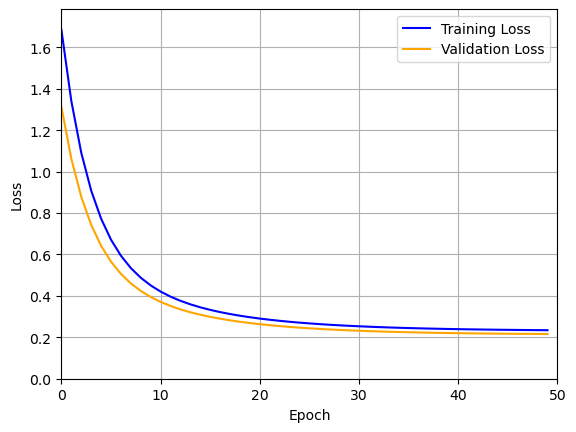

In [33]:

# Define the model class
class FareEstimator(nn.Module):
    def __init__(self, input_size):
        super(FareEstimator, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# Create the model, loss function, and optimizer
input_size = X_train.shape[1]
model = FareEstimator(input_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop with loss tracking
epochs = 50
train_losses = []
val_losses = []

# Initialize the plot
fig, ax = plt.subplots()
line1, = ax.plot([], [], label="Training Loss", color='blue')
line2, = ax.plot([], [], label="Validation Loss", color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.grid(True)

# Update the plot dynamically during training
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Track the loss
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test_tensor)
        val_loss = criterion(val_output, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    # Clear the previous plot
    clear_output(wait=True)
    
    # Update the plot data
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    
    # Adjust the x and y axis limits dynamically
    ax.set_xlim(0, epochs)
    ax.set_ylim(0, max(max(train_losses), max(val_losses)) + 0.1)
    
    # Redraw the plot
    display(fig)
    plt.pause(0.1)

# Disable interactive mode after training is done
plt.ioff()
plt.show()


In [34]:
# Save the trained model
model_path = '../models/fare_estimator.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/fare_estimator.pth
